In [22]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.autograd import Variable
import torchvision.models as models
import glob
import numpy as np
import pickle
#from tensorboardX import SummaryWriter
import time
import os,shutil,json
import argparse
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
#import natsort
#import easydict
from PIL import Image
#from skimage import io, transform
import random
import math
import torch.utils.data
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
#from efficientnet_pytorch import EfficientNet
import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
from RandAugment import RandAugment
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat

In [2]:
os.chdir('train/') # Data_Path
current_path = os.getcwd() # current folder
print('current_path', current_path)

current_path /opt/ml/train


In [3]:
load_df = pd.read_csv('train.csv')
load_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


60
18


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


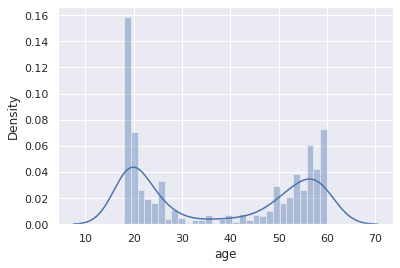

In [4]:
print(max(load_df.age))
print(min(load_df.age))
sns.set_theme()
sns.distplot(load_df['age'], kde=True, bins=30)

In [5]:
li = []
li2 = []
for idx, row in load_df.iterrows():
  path = glob.glob('images/'+row.path+'/*')
  li.append(path)
  li2.append([os.path.basename(x).split('.')[0][:-1] for x in path])
flatten_li = list(np.concatenate(li).flat)
flatten_li2 = list(np.concatenate(li2).flat)
#print(flatten_li2)

In [6]:
train_df = []
for row in load_df.itertuples(index=False):
  train_df.extend([list(row)]*7)
train_df = pd.DataFrame(train_df, columns=load_df.columns)
train_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000001,female,Asian,45,000001_female_Asian_45
2,000001,female,Asian,45,000001_female_Asian_45
3,000001,female,Asian,45,000001_female_Asian_45
4,000001,female,Asian,45,000001_female_Asian_45


In [7]:
train_df['path']=flatten_li
train_df['mask']=flatten_li2
train_df.head()

,id,gender,race,age,path,mask
0,000001,female,Asian,45,images/000001_female_Asian_45/mask4.jpg,mask
1,000001,female,Asian,45,images/000001_female_Asian_45/normal.jpg,norma
2,000001,female,Asian,45,images/000001_female_Asian_45/mask3.jpg,mask
3,000001,female,Asian,45,images/000001_female_Asian_45/mask1.jpg,mask
4,000001,female,Asian,45,images/000001_female_Asian_45/incorrect_mask.jpg,incorrect_mas


In [8]:
del train_df['id']
del train_df['race']
train_df.head()

,gender,age,path,mask
0,female,45,images/000001_female_Asian_45/mask4.jpg,mask
1,female,45,images/000001_female_Asian_45/normal.jpg,norma
2,female,45,images/000001_female_Asian_45/mask3.jpg,mask
3,female,45,images/000001_female_Asian_45/mask1.jpg,mask
4,female,45,images/000001_female_Asian_45/incorrect_mask.jpg,incorrect_mas


In [9]:
gender = train_df['gender'].unique()
#age = train_df['age'].unique()
mask = train_df['mask'].unique()
#print(gender, age, mask)
gender2idx = {o:i for i,o in enumerate(gender)}
#age2idx = {o:i for i,o in enumerate(age)}
mask2idx = {o:i for i,o in enumerate(mask)}

train_df['gender'] = train_df['gender'].apply(lambda x: gender2idx[x])
#train_df['age'] = train_df['age'].apply(lambda x: age2idx(x))
train_df['mask'] = train_df['mask'].apply(lambda x: mask2idx[x])

train_df.head()

,gender,age,path,mask
0,0,45,images/000001_female_Asian_45/mask4.jpg,0
1,0,45,images/000001_female_Asian_45/normal.jpg,1
2,0,45,images/000001_female_Asian_45/mask3.jpg,0
3,0,45,images/000001_female_Asian_45/mask1.jpg,0
4,0,45,images/000001_female_Asian_45/incorrect_mask.jpg,2


60
18


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


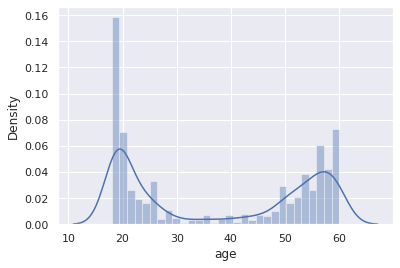

In [10]:
print(max(load_df.age))
print(min(load_df.age))
sns.set_theme()
sns.distplot(train_df['age'], kde=True, bins=30)

In [23]:
model_names = timm.list_models('*nf*', pretrained=True)
print(model_names)

['dm_nfnet_f0', 'dm_nfnet_f1', 'dm_nfnet_f2', 'dm_nfnet_f3', 'dm_nfnet_f4', 'dm_nfnet_f5', 'dm_nfnet_f6', 'eca_nfnet_l0', 'nf_regnet_b1', 'nf_resnet50', 'nfnet_l0']


In [11]:
class MultiTaskDataset(torch.utils.data.Dataset):
    def __init__(self, df, tf):
        self.path = list(df['path'])
        self.gender = list(df['gender'])
        self.age = list(df['age'])
        self.mask = list(df['mask'])

        self.transform = transforms.Compose([
            # transforms.Resize((224, 224)),  
            transforms.CenterCrop((350,256)),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])
        if tf:
            self.transform.transforms.insert(0,RandAugment(3,9))

    def __len__(self): return len(self.path)

    def __getitem__(self,idx):
        #dealing with the image
        im = PIL.Image.open(self.path[idx]).convert('RGB')
        im = self.transform(im)


        #dealing with the labels
        gender = torch.tensor(int(self.gender[idx]), dtype=torch.int64)
        age = torch.tensor(float(self.age[idx]), dtype=torch.float32)
        mask = torch.tensor(int(self.mask[idx]), dtype=torch.int64)
        
        return im.data, (gender, age.log_()/4.09, mask)

In [12]:
train_ds = MultiTaskDataset(train_df, tf=True)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
valid_ds = MultiTaskDataset(train_df, tf=False)
valid_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
data = DataBunch(train_dl, valid_dl)

In [13]:
class MultiTaskModel(nn.Module):
    """
    Creates a MTL model with the encoder from "arch" and with dropout multiplier ps.
    """
    def __init__(self, arch,ps=0.5):
        super(MultiTaskModel,self).__init__()
        self.encoder = create_body(arch, pretrained=False)        #fastai function that creates an encoder given an architecture
        self.fc1 = create_head(1024,2,ps=ps)    #fastai function that creates a head
        self.fc2 = create_head(1024,1,ps=ps)
        self.fc3 = create_head(1024,3,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        gender = self.fc1(x)
        age = torch.sigmoid(self.fc2(x))
        mask = self.fc3(x)

        return [gender, age, mask]

In [14]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, gender, age, mask):

        ce, mse = CrossEntropyFlat(), MSELossFlat()

        sages = (age*4.09).exp_()
        idx1 = ((sages > 19) & (sages<21)) | ((sages > 56) & (sages<=60))
        idx2 = ((sages >= 21) & (sages<28)) | ((sages > 48) & (sages<=56))
        idx3 = ((sages >= 28) & (sages<=48))
        loss0 = ce(preds[0], gender)
        loss1 = mse(preds[1], age) + 1.75 * mse(preds[1][idx1], age[idx1]) + 2.25 * mse(preds[1][idx2], age[idx2]) + 5 * mse(preds[1][idx3], age[idx3])         
        loss2 = ce(preds[2], mask)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        precision2 = torch.exp(-self.log_vars[2])
        loss2 = precision2*loss2 + self.log_vars[2]
        
        return loss0+loss1+loss2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 8.32E-03


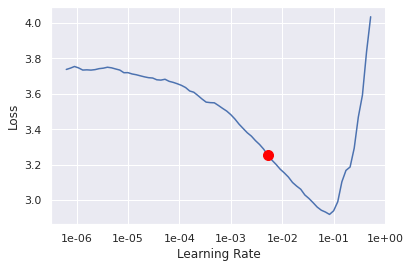

In [16]:
def acc_gender(preds, gender, age, mask): return accuracy(preds[0], gender)
def acc_age(preds, gender, age, mask): return root_mean_squared_error(preds[1], age)
def acc_mask(preds, gender, age, mask): return accuracy(preds[2], mask)
metrics = [acc_gender, acc_age, acc_mask]

model = MultiTaskModel(models.resnet34, ps=0.25)

loss_func = MultiTaskLossWrapper(3).to(data.device) #just making sure the loss is on the gpu

learn = Learner(data, model, loss_func=loss_func,opt_func=AdamW, callback_fns=ShowGraph, metrics=metrics)

#spliting the model so that I can use discriminative learning rates
#learn.split([learn.model.encoder[:6],
#              learn.model.encoder[6:],
#              nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

#first I'll train only the last layer group (the heads)

learn.unfreeze()
# learn.fit_one_cycle(10, 1e-4)
learn.lr_find()
learn.recorder.plot(suggestion=True)
#learn.fit_one_cycle(1, max_lr=1e-2)

epoch,train_loss,valid_loss,acc_gender,acc_age,acc_mask,time
0,1.780273,1.382334,0.662169,0.137512,0.761323,01:42


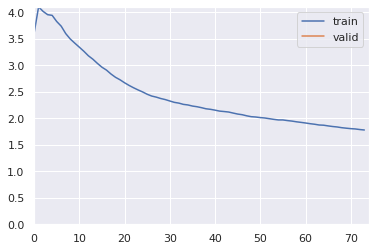

In [17]:
learn.fit_one_cycle(1, max_lr=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


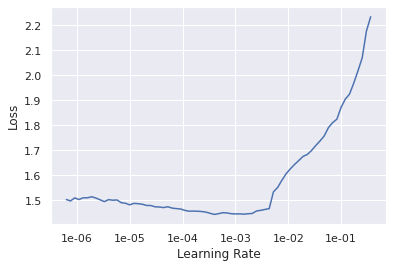

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_gender,acc_age,acc_mask,time
0,1.426968,1.381047,0.681905,0.145159,0.771799,01:42
1,1.367867,1.209336,0.706773,0.121386,0.790794,01:42
2,1.248565,1.092224,0.732328,0.122926,0.825185,01:41
3,1.109753,1.094536,0.758889,0.149847,0.861746,01:42
4,0.997930,0.826554,0.796402,0.115181,0.890476,01:43
5,0.889674,0.793117,0.813968,0.119093,0.908095,01:45
6,0.827578,0.722356,0.827672,0.118637,0.911746,01:42
7,0.757384,0.666434,0.842857,0.117056,0.922646,01:42
8,0.757543,1.008399,0.839153,0.158637,0.925661,01:42
9,0.729412,0.645144,0.861587,0.138756,0.938836,01:43


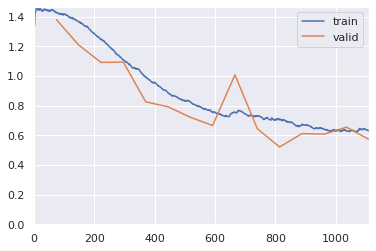

In [19]:
#learn.unfreeze()
learn.fit_one_cycle(15, max_lr=1e-4)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, max_lr=1e-7)

In [ ]:
trained_model = learn.model.cpu()

In [ ]:
sample_submission = pd.read_csv('/opt/ml/eval/info.csv')
sample_submission.head()

In [ ]:
class AgenethPredictor():
    def __init__(self, model):
        self.model = model
        #self.tfms = get_transforms()[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def predict(self,x):
        #x is a PIL Image
        img = PIL.Image.open('/opt/ml/eval/images/' + x).convert('RGB')
        x = transforms.CenterCrop((350,256))(img)
        x = transforms.Resize((224,224))(x)
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        #x = x.apply_tfms(self.tfms, size = 224)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        gender = torch.softmax(preds[0],1).argmax().item()
        age = int(torch.exp(preds[1]*4.09).item())
        mask = torch.softmax(preds[2],1).argmax().item()
        return gender, age, mask

In [ ]:
ageneth_predictor = AgenethPredictor(trained_model)


In [ ]:
img = PIL.Image.open('/opt/ml/eval/images/'+sample_submission.ImageID[1])
img

In [ ]:
%time ageneth_predictor.predict(sample_submission.ImageID[1])

In [ ]:
tmp_li = [
          [0, 1, 0],
          [0, 1, 1],
          [0, 1, 2],
          [0, 0, 0],
          [0, 0, 1],
          [0, 0, 2],
          [1, 1, 0],
          [1, 1, 1],
          [1, 1, 2],
          [1, 0, 0],
          [1, 0, 1],
          [1, 0, 2],
          [2, 1, 0],
          [2, 1, 1],
          [2, 1, 2],
          [2, 0, 0],
          [2, 0, 1],
          [2, 0, 2]
]
match = pd.DataFrame(tmp_li, columns = ['Mask', 'Gender', 'Age'])
match.head()

In [ ]:
from tqdm import tqdm
predicts = []
for path in tqdm(list(sample_submission['ImageID'])):
  p = ageneth_predictor.predict(path)
  #print(str(i)+'/'+str(len(sample_submission)))
  if p[1] < 30:
    ag = 0
  elif p[1] >= 60:
    ag=2
  else:
    ag=1
  p_match = match.loc[(match['Gender']== p[0]) & (match['Age']==ag) & (match['Mask']==p[2])].index.item()
  predicts.append(p_match)


In [ ]:
sample_submission['ans'] = predicts

In [ ]:
sample_submission.to_csv('/opt/ml/train/submission3.csv', mode='w', index=False)

In [ ]:
from tqdm import tqdm
predicts = []
for path in tqdm(list(sample_submission['ImageID'])):
  p = ageneth_predictor.predict(path)
  #print(str(i)+'/'+str(len(sample_submission)))
  if p[1] < 30:
    ag = 0
  elif p[1] >= 59:
    ag=2
  else:
    ag=1
  p_match = match.loc[(match['Gender']== p[0]) & (match['Age']==ag) & (match['Mask']==p[2])].index.item()
  predicts.append(p_match)
sample_submission['ans'] = predicts
sample_submission.to_csv('/opt/ml/train/submission4.csv', mode='w', index=False)

In [ ]:
from tqdm import tqdm
predicts = []
for path in tqdm(list(sample_submission['ImageID'])):
  p = ageneth_predictor.predict(path)
  #print(str(i)+'/'+str(len(sample_submission)))
  if p[1] < 30:
    ag = 0
  elif p[1] >= 45:
    ag=2
  else:
    ag=1
  p_match = match.loc[(match['Gender']== p[0]) & (match['Age']==ag) & (match['Mask']==p[2])].index.item()
  predicts.append(p_match)
sample_submission['ans'] = predicts
sample_submission.to_csv('/opt/ml/train/submission5.csv', mode='w', index=False)